# Resnet
This notebook contains a test of using resnet.

In [1]:
%matplotlib inline
import numpy as np
import torch
from torch.autograd import Variable
import torch.optim as optim
import torch.nn.functional as F
import os,sys
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import time


# import torch
import torchvision
# from torch import nn
# from torch import optim
# from torch.utils.data import DataLoader
from torchvision import transforms


#seed for reproducible results
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

In [2]:
# Helper functions

def load_image(infilename):
    data = mpimg.imread(infilename)
    return data

def img_float_to_uint8(img):
    rimg = img - np.min(img)
    rimg = (rimg / np.max(rimg) * 255).round().astype(np.uint8)
    return rimg

# Concatenate an image and its groundtruth
def concatenate_images(img, gt_img):
    nChannels = len(gt_img.shape)
    w = gt_img.shape[0]
    h = gt_img.shape[1]
    if nChannels == 3:
        cimg = np.concatenate((img, gt_img), axis=1)
    else:
        gt_img_3c = np.zeros((w, h, 3), dtype=np.uint8)
        gt_img8 = img_float_to_uint8(gt_img)          
        gt_img_3c[:,:,0] = gt_img8
        gt_img_3c[:,:,1] = gt_img8
        gt_img_3c[:,:,2] = gt_img8
        img8 = img_float_to_uint8(img)
        cimg = np.concatenate((img8, gt_img_3c), axis=1)
    return cimg

In [3]:
# Function that implements random cropping

from random import random

def uniform(a,b):
    return(a+(b-a)*random())

def img_rnd_crop(im, w, h, i = -1, j = -1):
    is_2d = len(im.shape) < 3
    imgwidth = im.shape[len(im.shape)-2]
    imgheight = im.shape[len(im.shape)-1]
    if (i == -1 and j == -1):
        i = int(uniform(0, imgwidth-w-1))
        j = int(uniform(0, imgheight-h-1))
    if is_2d:
        im_patch = im[i:i+w, j:j+h]
    else:
        im_patch = im[:, i:i+w, j:j+h]
    return im_patch, i, j

Load data.

In [4]:
end_train = 500 # normally = 90
end_validation = 550 # normally = 100

# Loading a set of 100 training images
root_dir = "training/"

image_dir = root_dir + "images/"
files = os.listdir(image_dir)
n = min(100, len(files)) # Load maximum 100 images
print("Loading " + str(n) + " images")
imgs = np.array([load_image(image_dir + files[i]) for i in range(n)]).swapaxes(1,3).swapaxes(2,3)
print(np.shape(imgs))

# train_input = imgs[0:end_train] #normally = 0:90
# validation_input = imgs[end_train:end_validation] #normally = 90:100

image_dir = root_dir + "groundtruth/"
files = os.listdir(image_dir)
n = min(100, len(files)) # Load maximum 100 images
print("Loading " + str(n) + " images")
grounds = [load_image(image_dir + files[i]) for i in range(n)]
print(np.shape(grounds))

imgs = np.array(imgs)
grounds = np.array(grounds)

# train_target = grounds[0:end_train] #normally = 0:90
# validation_target = grounds[end_train:end_validation] #normally = 90:100

Loading 100 images
(100, 3, 400, 400)
Loading 100 images
(100, 400, 400)


Crop data to their 256*256 counterparts.

In [5]:
def rotated_expansion(imgs):
    shape = [imgs.shape[i] for i in range(len(imgs.shape))]
    shape[0] = shape[0]*4 # there will be 4 times as many images after we rotate in each direction
    shape = tuple(shape)
    rotated_imgs = np.empty(shape)
    
    for index in range(int(shape[0]/4)):
        img = imgs[index]
        if(len(np.shape(img))>2):
            img90 = np.rot90(img.swapaxes(1,2).swapaxes(0,2)).swapaxes(0,2).swapaxes(1,2)
            img180 = np.rot90(img90.swapaxes(1,2).swapaxes(0,2)).swapaxes(0,2).swapaxes(1,2)
            img270 = np.rot90(img180.swapaxes(1,2).swapaxes(0,2)).swapaxes(0,2).swapaxes(1,2)
        else:
            img90 = np.rot90(img)
            img180 = np.rot90(img90)
            img270 = np.rot90(img180)
        
        rotated_imgs[index*4] = img
        rotated_imgs[index*4+1] = img90
        rotated_imgs[index*4+2] = img180
        rotated_imgs[index*4+3] = img270
    
    return rotated_imgs

rotated_grounds = rotated_expansion(grounds)
rotated_imgs = rotated_expansion(imgs)

def flipped_expansion(imgs):
    shape = [imgs.shape[i] for i in range(len(imgs.shape))]
    shape[0] = shape[0]*3 # there will be 4 times as many images after we rotate in each direction
    shape = tuple(shape)
    flipped_imgs = np.empty(shape)
    
    for index in range(int(shape[0]/3)):
        img = imgs[index]
        if(len(np.shape(img))>2):
            imgup = np.flipud(img.swapaxes(1,2).swapaxes(0,2)).swapaxes(0,2).swapaxes(1,2)
            imglr = np.fliplr(img.swapaxes(1,2).swapaxes(0,2)).swapaxes(0,2).swapaxes(1,2)
        else:
            imgup = np.flipud(img)
            imglr = np.fliplr(img)
        
        flipped_imgs[index*3] = img
        flipped_imgs[index*3+1] = imgup
        flipped_imgs[index*3+2] = imglr
    
    return flipped_imgs

flipped_rotated_grounds = flipped_expansion(rotated_grounds)
flipped_rotated_imgs = flipped_expansion(rotated_imgs)

display(np.shape(flipped_rotated_grounds))
display(np.shape(flipped_rotated_imgs))

(1200, 400, 400)

(1200, 3, 400, 400)

In [6]:
# crop images to their 256*256 counterparts
cropped_imgs = []
cropped_targets = []

for i in range(1200):
    cropped_img, k, l = img_rnd_crop(flipped_rotated_imgs[i], 256, 256)
    cropped_target, _, _ = img_rnd_crop(flipped_rotated_grounds[i], 256, 256, k, l)
    cropped_imgs.append(cropped_img)
    cropped_targets.append(cropped_target)

In [7]:
import random

x = list(range(1200))
random.shuffle(x)

train_input = [cropped_imgs[i] for i in x[:end_train]] #normally = 0:1080
validation_input = [cropped_imgs[i] for i in x[end_train:end_validation]] #normally = 1080:1200



train_target = [cropped_targets[i] for i in x[:end_train]] #normally = 0:1080
validation_target = [cropped_targets[i] for i in x[end_train:end_validation]] #normally = 1080:1200

display(np.shape(train_input))
display(np.shape(validation_input))
display(np.shape(train_target))
display(np.shape(validation_target))

(500, 3, 256, 256)

(50, 3, 256, 256)

(500, 256, 256)

(50, 256, 256)

## Pytorch module

This module contains the FCN based on the CNN module

### Module structure

We use Resnet-50

In [8]:
# This class takes our input of size 400*400 and enlarges it to size 512*512

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')



res50_conv = torch.nn.Sequential(*list(
        torchvision.models.resnet50(pretrained=True).children())[:-2])  # get all layers except avg-pool & fc


# for p in res50_conv.parameters():
#     p.requires_grad=False

model = torch.nn.Sequential(
    res50_conv,  # encoder
    torch.nn.ConvTranspose2d(2048, 1024, kernel_size=4, stride=2, padding=1),  # 2x upsample
    torch.nn.BatchNorm2d(1024),
    torch.nn.ReLU(),
    torch.nn.ConvTranspose2d(1024, 512, kernel_size=4, stride=2, padding=1),  # 2x upsample
    torch.nn.BatchNorm2d(512),
    torch.nn.ReLU(),
    torch.nn.ConvTranspose2d(512, 256, kernel_size=6, stride=4, padding=1),  # 4x upsample
    torch.nn.BatchNorm2d(256),
    torch.nn.ReLU(),
    torch.nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  # 2x upsample
    torch.nn.BatchNorm2d(128),
    torch.nn.ReLU(),
    torch.nn.Conv2d(128, 1, kernel_size=1, stride=1, padding=0),  # logits per pixel
    torch.nn.Sigmoid()  # predictions per pixel  # could remove and use BCEWithLogitsLoss instead of BCELoss.
)
model.to(device)



for p in model.parameters():
    try:
        torch.nn.init.xavier_normal_(p)
    except ValueError:
        pass
    
    
model = torch.load('best_modelgood150.pth')
model.eval()

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64, 256

New Lossfunction

In [9]:
from PIL import Image


class GrayscaleAndThreshold:
    """ Reduce image to a single binary channel """
    def __init__(self, level=0.1):
        self.level = level

    def __call__(self, img):
        img = img.convert('L')  # 0..255, single channel

        np_img = np.array(img, dtype=np.uint8)
        np_img[np_img > self.level*255] = 255
        np_img[np_img <= self.level*255] = 0

        img = Image.fromarray(np_img, 'L')

        return img

class WeightedBCELoss(torch.nn.BCELoss):
    def __init__(self, class_weights=None):  # does not support weight, size_average, reduce, reduction
        super().__init__(reduction='none')
        if class_weights is None:
            class_weights = torch.ones(2)
        self.class_weights = torch.as_tensor(class_weights)

    def forward(self, input, target):
        raw_loss = super().forward(input, target)
        class_weights = self.class_weights.to(input.device)
        weight_matrix = class_weights[0]*(1-target) + class_weights[1]*target
        loss = weight_matrix * raw_loss
        loss = loss.mean()  # reduction='elementwise_mean'
        return loss


def compute_class_weights(imgs):
    mask_transform = transforms.Compose([
        GrayscaleAndThreshold(),
        transforms.ToTensor()
        ])

    road_pxs = 0
    bg_pxs = 0
    for img in imgs:
        img = Image.fromarray(np.uint8(img*255))
        mask_tr = torch.squeeze(mask_transform(img)).numpy().astype(int)
        road_pxs += mask_tr.sum()
        bg_pxs += (1 - mask_tr).sum()

    bg_px_weight = (road_pxs + bg_pxs) / (2 * bg_pxs)  # "class 0"
    road_px_weight = (road_pxs + bg_pxs) / (2 * road_pxs)  # "class 1"

    return bg_px_weight, road_px_weight


In [10]:
# Data statistics
class_weights = compute_class_weights(train_target)

criterion = WeightedBCELoss(class_weights)

This model optimized with adam and cross entropy will converge to all-black images every time

## Training the model

To shorten the computationnal time we will use a smaller amount of images to do tests.

### Instantiate the model, loss function and optimizer

In [11]:
# We will optimize the cross-entropy loss using adam algorithm
loss_function = torch.nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)
optimizer = optim.SGD(model.parameters(), lr=3.75e-2, momentum=0.9)

In [12]:
from torchvision import transforms

def trainNet(model, n_epochs):
    loss_train_epoch =[]
    loss_validation_epoch =[]
    
    #Time for printing
    training_start_time = time.time()
    
    #Loop for n_epochs
    for epoch in range(n_epochs):
        
        total_loss = 0.0
        
        for index in range(np.shape(train_input)[0]):
            model.train()
            
            input_image = torch.tensor(train_input[index]).unsqueeze(0).to(device)
            target_image = torch.tensor(train_target[index]).to(device)
            
            #Forward pass, backward pass, optimize
            outputs = model(input_image.float())
            loss = criterion(outputs, target_image.float())
            
            #Set the parameter gradients to zero
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            #Print statistics
            total_loss += loss.item() * input_image.size(0)
            
            print("Epoch", epoch, ", image", index, ", image loss:", loss.item(), ", time elapsed:", time.time() - training_start_time)
            
        #At the end of the epoch, do a pass on the validation set
        total_val_loss = 0
        for index in range(np.shape(validation_input)[0]):
            model.eval()
                        
            
            input_image = torch.tensor(validation_input[index]).unsqueeze(0).to(device)
            target_image = torch.tensor(validation_target[index]).to(device)
            
            #Forward pass
            val_outputs = model(input_image.float())
            val_loss = criterion(val_outputs, target_image.float())
            total_val_loss += val_loss.item() * input_image.size(0)
            
        print("Validation loss for epoch", epoch, ":", total_val_loss/np.shape(validation_input)[0])
        
        loss_train_epoch.append(total_loss/np.shape(train_input)[0])
        loss_validation_epoch.append(total_val_loss/np.shape(validation_input)[0])
        
    print("Training finished, took {:.2f}s".format(time.time() - training_start_time))
    
    torch.save(model, 'best_model.pth')
    return loss_train_epoch, loss_validation_epoch

In [13]:
losstrain, loss_validation = trainNet(model, 1)

C:\Users\morin\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:498: UserWarning: Using a target size (torch.Size([256, 256])) that is different to the input size (torch.Size([1, 1, 256, 256])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Epoch 0 , image 0 , image loss: 0.3097056448459625 , time elapsed: 4.21436619758606
Epoch 0 , image 1 , image loss: 0.3110325336456299 , time elapsed: 4.661810398101807
Epoch 0 , image 2 , image loss: 0.3635951280593872 , time elapsed: 5.0732128620147705
Epoch 0 , image 3 , image loss: 0.23882217705249786 , time elapsed: 5.488699913024902
Epoch 0 , image 4 , image loss: 0.8625586628913879 , time elapsed: 5.88812255859375
Epoch 0 , image 5 , image loss: 0.46369022130966187 , time elapsed: 6.29561710357666
Epoch 0 , image 6 , image loss: 1.59879732131958 , time elapsed: 6.70702862739563
Epoch 0 , image 7 , image loss: 0.31536614894866943 , time elapsed: 7.114517450332642
Epoch 0 , image 8 , image loss: 0.2485264539718628 , time elapsed: 7.541912317276001
Epoch 0 , image 9 , image loss: 1.1139189004898071 , time elapsed: 7.953397512435913
Epoch 0 , image 10 , image loss: 0.33683472871780396 , time elapsed: 8.364853858947754
Epoch 0 , image 11 , image loss: 0.7363221645355225 , time elapse

Epoch 0 , image 95 , image loss: 0.7003282904624939 , time elapsed: 42.685128927230835
Epoch 0 , image 96 , image loss: 0.6740098595619202 , time elapsed: 43.10057973861694
Epoch 0 , image 97 , image loss: 0.6926676034927368 , time elapsed: 43.53998589515686
Epoch 0 , image 98 , image loss: 0.8046532869338989 , time elapsed: 43.9594509601593
Epoch 0 , image 99 , image loss: 0.873465895652771 , time elapsed: 44.38285803794861
Epoch 0 , image 100 , image loss: 0.8201673030853271 , time elapsed: 44.79830360412598
Epoch 0 , image 101 , image loss: 0.5728163719177246 , time elapsed: 45.21774101257324
Epoch 0 , image 102 , image loss: 0.6777503490447998 , time elapsed: 45.62524080276489
Epoch 0 , image 103 , image loss: 0.6023149490356445 , time elapsed: 46.036646366119385
Epoch 0 , image 104 , image loss: 1.7005159854888916 , time elapsed: 46.44409942626953
Epoch 0 , image 105 , image loss: 0.5009849071502686 , time elapsed: 46.871569871902466
Epoch 0 , image 106 , image loss: 2.08273744583

Epoch 0 , image 189 , image loss: 0.6240768432617188 , time elapsed: 80.65034890174866
Epoch 0 , image 190 , image loss: 0.5170552730560303 , time elapsed: 81.04582285881042
Epoch 0 , image 191 , image loss: 0.5352092385292053 , time elapsed: 81.44528865814209
Epoch 0 , image 192 , image loss: 0.5004024505615234 , time elapsed: 81.84479808807373
Epoch 0 , image 193 , image loss: 0.5714386701583862 , time elapsed: 82.24821472167969
Epoch 0 , image 194 , image loss: 0.8055638670921326 , time elapsed: 82.65566992759705
Epoch 0 , image 195 , image loss: 0.7430962324142456 , time elapsed: 83.07116198539734
Epoch 0 , image 196 , image loss: 0.5485028624534607 , time elapsed: 83.47060585021973
Epoch 0 , image 197 , image loss: 0.5868790149688721 , time elapsed: 83.862056016922
Epoch 0 , image 198 , image loss: 0.349178284406662 , time elapsed: 84.27752041816711
Epoch 0 , image 199 , image loss: 0.2672077715396881 , time elapsed: 84.69693946838379
Epoch 0 , image 200 , image loss: 0.5797023773

Epoch 0 , image 282 , image loss: 0.4881945550441742 , time elapsed: 118.40385866165161
Epoch 0 , image 283 , image loss: 0.4676143229007721 , time elapsed: 118.80731534957886
Epoch 0 , image 284 , image loss: 0.4758458733558655 , time elapsed: 119.20678520202637
Epoch 0 , image 285 , image loss: 1.015733242034912 , time elapsed: 119.61024594306946
Epoch 0 , image 286 , image loss: 0.364607036113739 , time elapsed: 120.02176117897034
Epoch 0 , image 287 , image loss: 0.4987183213233948 , time elapsed: 120.42910528182983
Epoch 0 , image 288 , image loss: 0.3642680048942566 , time elapsed: 120.8284056186676
Epoch 0 , image 289 , image loss: 0.47582364082336426 , time elapsed: 121.24147415161133
Epoch 0 , image 290 , image loss: 0.4052099585533142 , time elapsed: 121.65865588188171
Epoch 0 , image 291 , image loss: 0.4051685035228729 , time elapsed: 122.06114315986633
Epoch 0 , image 292 , image loss: 1.0808148384094238 , time elapsed: 122.47294116020203
Epoch 0 , image 293 , image loss: 

Epoch 0 , image 375 , image loss: 0.44147342443466187 , time elapsed: 156.03457880020142
Epoch 0 , image 376 , image loss: 0.32940614223480225 , time elapsed: 156.45401549339294
Epoch 0 , image 377 , image loss: 0.36929798126220703 , time elapsed: 156.87744975090027
Epoch 0 , image 378 , image loss: 0.3785947859287262 , time elapsed: 157.29293394088745
Epoch 0 , image 379 , image loss: 0.324018657207489 , time elapsed: 157.72036862373352
Epoch 0 , image 380 , image loss: 0.4554569721221924 , time elapsed: 158.12777590751648
Epoch 0 , image 381 , image loss: 0.7077904939651489 , time elapsed: 158.53926134109497
Epoch 0 , image 382 , image loss: 0.9305052161216736 , time elapsed: 158.94673252105713
Epoch 0 , image 383 , image loss: 0.5030615329742432 , time elapsed: 159.36213421821594
Epoch 0 , image 384 , image loss: 0.47277653217315674 , time elapsed: 159.78955554962158
Epoch 0 , image 385 , image loss: 0.4172080159187317 , time elapsed: 160.2050004005432
Epoch 0 , image 386 , image lo

Epoch 0 , image 468 , image loss: 0.4270249903202057 , time elapsed: 194.39926624298096
Epoch 0 , image 469 , image loss: 0.40839439630508423 , time elapsed: 194.80672097206116
Epoch 0 , image 470 , image loss: 0.5586074590682983 , time elapsed: 195.20618772506714
Epoch 0 , image 471 , image loss: 0.3426464796066284 , time elapsed: 195.62962007522583
Epoch 0 , image 472 , image loss: 0.36594659090042114 , time elapsed: 196.0370752811432
Epoch 0 , image 473 , image loss: 0.3531048893928528 , time elapsed: 196.4445309638977
Epoch 0 , image 474 , image loss: 0.36766767501831055 , time elapsed: 196.847998380661
Epoch 0 , image 475 , image loss: 0.45712393522262573 , time elapsed: 197.25944113731384
Epoch 0 , image 476 , image loss: 0.4531586170196533 , time elapsed: 197.66689801216125
Epoch 0 , image 477 , image loss: 0.37505924701690674 , time elapsed: 198.0783452987671
Epoch 0 , image 478 , image loss: 0.27232903242111206 , time elapsed: 198.48585391044617
Epoch 0 , image 479 , image los

C:\Users\morin\Anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Sequential. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\morin\Anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Conv2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\morin\Anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type BatchNorm2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\morin\Anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ReLU. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\

In [28]:
input_image = torch.tensor(validation_input[5]).unsqueeze(0)
target_image = torch.tensor(validation_target[5]).unsqueeze(0)
           
#Forward pass
val_output = model(input_image.to(device).float())
output_image = val_output[0,0]

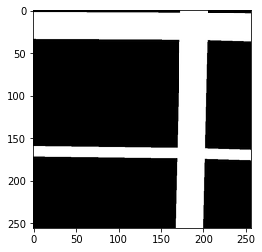

In [29]:
plt.imshow(target_image.squeeze(0), cmap='Greys_r')

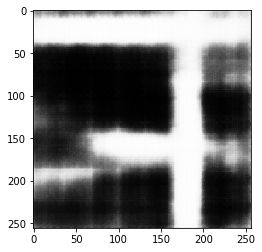

In [30]:
plt.imshow(output_image.detach().cpu().numpy(), cmap='Greys_r')

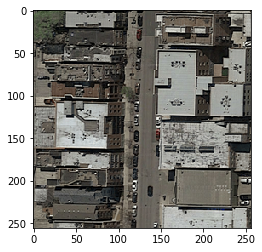

In [27]:
plt.imshow(validation_input[1].swapaxes(1,2).swapaxes(0,2))

In [18]:
np.savetxt('losstrain.csv', losstrain, delimiter=',')
np.savetxt('loss_validation.csv', loss_validation, delimiter=',')


Load the test data

In [19]:
root_dir = "test_set_images/"
test_images=[]
for i in range(1, 51):
    image_filename = root_dir + "test_" + str(i) + "/test_" + str(i) + '.png'
    test_images.append(np.array(load_image(image_filename)).swapaxes(0,2).swapaxes(1,2))
    test_images
print(np.shape(test_images))

(50, 3, 608, 608)


The file is bigger than 100*100! we need to cut it into 100*100 parts.

In [20]:

crop = 256
masks = []
for test_image in test_images:
    _, im_height, im_width = np.shape(test_image)
    imgheight = test_image.shape[1]
    imgwidth = test_image.shape[2]
    mask = torch.zeros(1, imgheight, imgwidth)
    for i in range(0, imgheight, crop):
        for j in range(0, imgwidth, crop):
            # when the crop is bigger than the image size, we increase the temporary image with 0
            if(i+crop>imgheight and j+crop>imgwidth):
                im_patch = np.zeros([3,crop,crop],dtype = np.float32)
                im_patch[:, :imgheight-i, :imgwidth-j] = test_image[:, i:imgheight, j:imgwidth]
                im_patch = torch.tensor(im_patch).unsqueeze(0).to(device)
                mask[:, i:imgheight, j:imgwidth] = model(im_patch.float()).detach()[0,0,:imgheight-i,:imgwidth-j]
            
            elif(i+crop>imgheight):
                im_patch = np.zeros([3,crop,crop],dtype = np.float32)
                im_patch[:, :imgheight-i, :] = test_image[:, i:imgheight, j:j+crop]
                im_patch = torch.tensor(im_patch).unsqueeze(0).to(device)
                mask[:, i:imgheight, j:j+crop] = model(im_patch.float()).detach()[0,0,:imgheight-i,:]
            
            elif(j+crop>imgwidth):
                im_patch = np.zeros([3,crop,crop])
                im_patch[:, :, :imgwidth-j] = test_image[:, i:i+crop, j:imgwidth]
                im_patch = torch.tensor(im_patch).unsqueeze(0).to(device)
                mask[:, i:i+crop, j:imgwidth] = model(im_patch.float()).detach()[0,0,:,:imgwidth-j]
            
            else: # cas normal
                im_patch = test_image[:, i:i+crop, j:j+crop]
                im_patch = torch.tensor(im_patch).unsqueeze(0).to(device)
                mask[:, i:i+crop, j:j+crop] = model(im_patch).detach()[0,0,:,:]
    masks.append(mask.numpy())

In [21]:
import os
import numpy as np
import matplotlib.image as mpimg
import re

foreground_threshold = 0.25 # percentage of pixels > 1 required to assign a foreground label to a patch

# assign a label to a patch
def patch_to_label(patch):
    df = np.mean(patch)
    if df > foreground_threshold:
        return 1
    else:
        return 0


def mask_to_submission_strings(image, img_number):
    """Reads a single image and outputs the strings that should go into the submission file"""
    patch_size = 16
    for j in range(0, image.shape[1], patch_size):
        for i in range(0, image.shape[2], patch_size):
            patch = image[0][i:i + patch_size, j:j + patch_size]
            label = patch_to_label(patch)
            yield("{:03d}_{}_{},{}".format(img_number, j, i, label))


def masks_to_submission(submission_filename, *images):
    """Converts images into a submission file"""
    with open(submission_filename, 'w') as f:
        f.write('id,prediction\n')
        i=int(0)
        for image in images[0:]:
            i+=1
            f.writelines('{}\n'.format(s) for s in mask_to_submission_strings(image,i))


In [22]:
submission_filename = 'submission.csv'
masks_to_submission(submission_filename, *masks)